# NB1: Extraction Verification & Daily ETL Validation

**Current Phase:** Data Extraction & Verification

**Workflow:**
1. **Extraction Verification** ← START HERE (após `make extract`)
   - Check if Apple inapp and Zepp cloud foram extraídos
   - Verificar integridade dos arquivos
   - Visualizar estrutura de diretórios
   
2. **Biomarkers Extraction** (após `make biomarkers`)
   - Verificar features de HRV, Sleep, Activity, Circadian
   
3. **EDA & Summary** (após `make labels`)
   - Análise exploratória dos dados
   - Estatísticas descritivas
   - Visualizações

**Run these commands before proceeding:**
```bash
make extract PID=P000001 SNAPSHOT=2025-11-07 ZEPP_ZIP_PASSWORD=pLOeJaNn
make biomarkers PID=P000001 SNAPSHOT=2025-11-07
make labels PID=P000001 SNAPSHOT=2025-11-07
```


# NB1: Daily ETL Validation & EDA

**Purpose:** Validate daily ETL outputs from `joined_features_daily.csv` and surface actionable insights for researcher/participant.

**Inputs:**
- `data/etl/<PID>/<SNAPSHOT>/joined/joined_features_daily.csv` (primary source of truth)
- Fallback: `features/<domain>/**/features_daily.csv` if primary unavailable
- `enriched/prejoin/**/enriched_*.csv` (enriched features)

**Outputs:**
- `reports/nb1_eda_summary.md` — Human-readable summary
- `reports/nb1_feature_stats.csv` — Per-column descriptive statistics
- `reports/plots/*.png` — Inline visualizations
- `reports/nb1_manifest.json` — Metadata & artifact manifest
- `latest/` — Mirror with symlinks for quick access

**Version:** v1.0 | **Date:** 2025-11-06 | **Environment:** Local, offline, no internet calls

In [45]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from datetime import datetime, timedelta
import textwrap
from collections import defaultdict
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Log helper
def log(msg):
    print(f"[NB1] {msg}")

# Resolve notebook directory and repo root
import os
notebook_dir = Path(os.getcwd())
repo_root = notebook_dir.parent  # Go up from /notebooks to project root

log(f"Notebook dir: {notebook_dir}")
log(f"Repo root: {repo_root}")
log("Environment ready ✓")

# ============================================================================
# SECTION 1: CONFIG & PATHS
# ============================================================================

# User Parameters
PID = "P000001"
SNAPSHOT = "auto"  # or "YYYY-MM-DD"

# Base paths (resolve from repo root)
BASE = repo_root / "data" / "etl" / PID
OUT = repo_root / "reports"
PLOTS = OUT / "plots"
LATEST = repo_root / "latest"

log(f"BASE path: {BASE}")

# Resolve SNAPSHOT="auto" to latest snapshot folder
if SNAPSHOT == "auto":
    if BASE.exists():
        snapshots = sorted([d.name for d in BASE.iterdir() if d.is_dir()])
        if snapshots:
            SNAPSHOT = snapshots[-1]
            log(f"Resolved SNAPSHOT='auto' → '{SNAPSHOT}'")
        else:
            raise ValueError(f"No snapshots found under {BASE}")
    else:
        raise ValueError(f"BASE path {BASE} does not exist")
else:
    log(f"Using SNAPSHOT='{SNAPSHOT}'")

# Define JOINED path
JOINED = BASE / SNAPSHOT / "joined" / "joined_features_daily.csv"
log(f"JOINED path: {JOINED}")

# Create output directories
OUT.mkdir(parents=True, exist_ok=True)
PLOTS.mkdir(parents=True, exist_ok=True)
LATEST.mkdir(parents=True, exist_ok=True)

# Verify JOINED exists
if not JOINED.exists():
    raise FileNotFoundError(f"JOINED file not found: {JOINED}")

log(f"✓ Config ready | PID={PID} | SNAPSHOT={SNAPSHOT} | OUT={OUT}")

[NB1] Notebook dir: c:\dev\practicum2-nof1-adhd-bd\notebooks
[NB1] Repo root: c:\dev\practicum2-nof1-adhd-bd
[NB1] Environment ready ✓
[NB1] BASE path: c:\dev\practicum2-nof1-adhd-bd\data\etl\P000001
[NB1] Resolved SNAPSHOT='auto' → '2025-11-07'
[NB1] JOINED path: c:\dev\practicum2-nof1-adhd-bd\data\etl\P000001\2025-11-07\joined\joined_features_daily.csv
[NB1] ✓ Config ready | PID=P000001 | SNAPSHOT=2025-11-07 | OUT=c:\dev\practicum2-nof1-adhd-bd\reports


In [ ]:
# ============================================================================
# SECTION 1A: EXTRACTION VERIFICATION
# ============================================================================

def check_extraction(pid="P000001", snapshot=None):
    """Verify Apple inapp and Zepp cloud extraction integrity."""
    
    base = repo_root / "data" / "etl" / pid
    
    # Auto-resolve snapshot if not provided
    if snapshot is None:
        if base.exists():
            snapshots = sorted([d.name for d in base.iterdir() if d.is_dir()])
            snapshot = snapshots[-1] if snapshots else None
        if not snapshot:
            print("❌ No snapshots found. Run: make extract")
            return False
    
    snapshot_dir = base / snapshot
    extracted_dir = snapshot_dir / "extracted"
    
    print(f"\n{'='*70}")
    print(f"EXTRACTION VERIFICATION: {pid} / {snapshot}")
    print(f"{'='*70}\n")
    
    # Check Apple INAPP
    print("🍎 APPLE INAPP:")
    apple_dir = extracted_dir / "apple" / "inapp"
    if apple_dir.exists():
        apple_export = apple_dir / "apple_health_export"
        xml_file = apple_export / "export.xml" if apple_export.exists() else None
        
        # Count CSV files
        csv_files = list(apple_dir.glob("*.csv"))
        print(f"   ✓ Directory exists: {apple_dir}")
        print(f"   ✓ CSV files extracted: {len(csv_files)}")
        if xml_file and xml_file.exists():
            print(f"   ✓ export.xml found: {xml_file.stat().st_size / 1024:.1f} KB")
        else:
            print(f"   ⚠ export.xml not found")
        
        # Sample CSV files
        if csv_files:
            print(f"   Sample files: {[f.name for f in csv_files[:3]]}")
    else:
        print(f"   ❌ Directory not found: {apple_dir}")
        return False
    
    # Check Zepp CLOUD
    print("\n⌚ ZEPP CLOUD:")
    zepp_dir = extracted_dir / "zepp" / "cloud"
    if zepp_dir.exists():
        print(f"   ✓ Directory exists: {zepp_dir}")
        
        # Check each expected subdirectory
        subdir_counts = {}
        for subdir in ["HEARTRATE_AUTO", "SLEEP", "ACTIVITY_STAGE", "ACTIVITY_MINUTE"]:
            sub_path = zepp_dir / subdir
            if sub_path.exists():
                csv_count = len(list(sub_path.glob("*.csv")))
                subdir_counts[subdir] = csv_count
                print(f"   ✓ {subdir}: {csv_count} CSV file(s)")
            else:
                print(f"   ⚠ {subdir}: Not found")
        
        if not subdir_counts:
            print("   ❌ No subdirectories found")
            return False
    else:
        print(f"   ❌ Directory not found: {zepp_dir}")
        return False
    
    # Check JOINED features
    print("\n📊 JOINED FEATURES:")
    joined_file = snapshot_dir / "joined" / "joined_features_daily.csv"
    if joined_file.exists():
        df_test = pd.read_csv(joined_file, nrows=1)
        file_size_mb = joined_file.stat().st_size / (1024 * 1024)
        print(f"   ✓ joined_features_daily.csv: {file_size_mb:.1f} MB")
        print(f"   ✓ Columns: {df_test.shape[1]}")
        print(f"   ✓ First columns: {list(df_test.columns[:5])}")
    else:
        print(f"   ⚠ joined_features_daily.csv not found (optional at this stage)")
    
    # Check Biomarkers
    print("\n🔬 BIOMARKERS:")
    biomarkers_file = snapshot_dir / "joined" / "joined_features_daily_biomarkers.csv"
    if biomarkers_file.exists():
        df_bio = pd.read_csv(biomarkers_file, nrows=1)
        print(f"   ✓ joined_features_daily_biomarkers.csv exists")
        print(f"   ✓ Biomarker columns: {[c for c in df_bio.columns if 'hrv' in c.lower() or 'sleep' in c.lower()][:5]}")
    else:
        print(f"   ⏳ Biomarkers not yet extracted (run: make biomarkers)")
    
    print(f"\n{'='*70}\n")
    return True

# Run verification
extraction_ok = check_extraction(PID, SNAPSHOT if SNAPSHOT != "auto" else None)
if not extraction_ok:
    print("\n⚠️  Extraction incomplete. Please run:")
    print("   make extract PID=P000001 SNAPSHOT=2025-11-07 ZEPP_ZIP_PASSWORD=pLOeJaNn")


In [46]:
# ============================================================================
# SECTION 2: SAFE LOAD & BASIC SCHEMA
# ============================================================================

# Load with date parsing
df = pd.read_csv(JOINED, parse_dates=['date'])

# Normalize date to midnight
df['date'] = pd.to_datetime(df['date']).dt.normalize()

# Sort by date
df = df.sort_values('date').reset_index(drop=True)

# Drop duplicate rows (keep latest by index)
n_before = len(df)
df = df.drop_duplicates(subset=['date'], keep='last').reset_index(drop=True)
n_after = len(df)
if n_before > n_after:
    log(f"⚠ Removed {n_before - n_after} duplicate date rows")

# Basic info
n_rows, n_cols = df.shape
date_min = df['date'].min()
date_max = df['date'].max()
date_range = (date_max - date_min).days + 1

log(f"Loaded {n_rows} rows × {n_cols} cols | Date range: {date_min.date()} to {date_max.date()} ({date_range} days)")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nLast 5 rows:")
print(df.tail())

# Verify monotonic dates
if not df['date'].is_monotonic_increasing:
    log("⚠ Dates are not monotonic! Sorting...")
    df = df.sort_values('date').reset_index(drop=True)
else:
    log("✓ Dates are monotonic")

print(f"\nDataFrame Info:")
print(df.info())

[NB1] ⚠ Removed 5793 duplicate date rows
[NB1] Loaded 2722 rows × 40 cols | Date range: 2018-04-06 to 2025-10-22 (2757 days)

First 5 rows:
        date  apple_hr_mean  apple_hr_max  apple_n_hr  zepp_hr_mean  \
0 2018-04-06            NaN           NaN         NaN           NaN   
1 2018-04-07            NaN           NaN         NaN           NaN   
2 2018-04-08            NaN           NaN         NaN           NaN   
3 2018-04-09            NaN           NaN         NaN           NaN   
4 2018-04-10            NaN           NaN         NaN           NaN   

   zepp_hr_max  zepp_n_hr  hr_mean  n_hr source_domain  apple_steps  \
0          NaN        NaN      NaN   NaN      activity      6923.00   
1          NaN        NaN      NaN   NaN      activity      6094.00   
2          NaN        NaN      NaN   NaN      activity      4787.00   
3          NaN        NaN      NaN   NaN      activity      2710.00   
4          NaN        NaN      NaN   NaN      activity      5753.00   

   app

In [47]:
# ============================================================================
# SECTION 3: COLUMN INVENTORY & DTYPE COERCION
# ============================================================================

# Define expected columns by domain
cols_activity_apple = ['apple_steps', 'apple_distance_m', 'apple_active_kcal', 'apple_exercise_min',
                       'apple_stand_hours', 'apple_move_goal_kcal', 'apple_exercise_goal_min',
                       'apple_stand_goal_hours', 'apple_rings_close_move', 'apple_rings_close_exercise',
                       'apple_rings_close_stand']
cols_activity_zepp = ['zepp_act_steps', 'zepp_act_distance_km', 'zepp_act_cal_active', 'zepp_act_cal_total',
                      'zepp_act_sedentary_min', 'zepp_act_stand_hours', 'zepp_act_sport_sessions',
                      'zepp_act_exercise_min', 'zepp_act_score_daily']
cols_activity_coalesced = ['act_steps', 'act_active_min']
cols_cardio = ['apple_hr_mean', 'apple_hr_std', 'apple_n_hr', 'zepp_hr_mean', 'zepp_hr_std',
               'zepp_n_hr', 'hr_mean', 'hr_std', 'n_hr']
cols_sleep = ['zepp_slp_total_h', 'zepp_slp_deep_h', 'zepp_slp_light_h', 'zepp_slp_rem_h', 'sleep_total_h']
cols_label = ['label', 'label_source']
cols_segment = ['segment_id']

all_numeric_expected = (cols_activity_apple + cols_activity_zepp + cols_activity_coalesced +
                        cols_cardio + cols_sleep)

# Coerce numeric columns
numeric_cols = df.select_dtypes(include=['object', 'float64', 'int64']).columns
for col in numeric_cols:
    if col not in ['date', 'label', 'label_source', 'segment_id', 'source_domain']:
        try:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        except:
            pass

# Report coverage by domain
log("\n=== COLUMN INVENTORY ===")

domains = {
    'Activity (Apple)': cols_activity_apple,
    'Activity (Zepp)': cols_activity_zepp,
    'Activity (Coalesced)': cols_activity_coalesced,
    'Cardio': cols_cardio,
    'Sleep': cols_sleep,
}

for domain_name, cols in domains.items():
    present = [c for c in cols if c in df.columns]
    missing = [c for c in cols if c not in df.columns]
    print(f"\n{domain_name}:")
    print(f"  Present ({len(present)}): {present[:5]}{'...' if len(present) > 5 else ''}")
    if missing:
        print(f"  Missing ({len(missing)}): {missing[:5]}{'...' if len(missing) > 5 else ''}")

# Check for enriched columns (*_7d, *_zscore)
enriched_7d = [c for c in df.columns if '_7d' in c]
enriched_zscore = [c for c in df.columns if '_zscore' in c]
print(f"\nEnriched (*_7d): {len(enriched_7d)} columns {enriched_7d[:3]}{'...' if len(enriched_7d) > 3 else ''}")
print(f"Enriched (*_zscore): {len(enriched_zscore)} columns {enriched_zscore[:3]}{'...' if len(enriched_zscore) > 3 else ''}")

log("✓ Column inventory complete")

[NB1] 
=== COLUMN INVENTORY ===

Activity (Apple):
  Present (11): ['apple_steps', 'apple_distance_m', 'apple_active_kcal', 'apple_exercise_min', 'apple_stand_hours']...

Activity (Zepp):
  Present (4): ['zepp_act_cal_total', 'zepp_act_sedentary_min', 'zepp_act_sport_sessions', 'zepp_act_score_daily']
  Missing (5): ['zepp_act_steps', 'zepp_act_distance_km', 'zepp_act_cal_active', 'zepp_act_stand_hours', 'zepp_act_exercise_min']

Activity (Coalesced):
  Present (2): ['act_steps', 'act_active_min']

Cardio:
  Present (6): ['apple_hr_mean', 'apple_n_hr', 'zepp_hr_mean', 'zepp_n_hr', 'hr_mean']...
  Missing (3): ['apple_hr_std', 'zepp_hr_std', 'hr_std']

Sleep:
  Present (4): ['zepp_slp_total_h', 'zepp_slp_deep_h', 'zepp_slp_light_h', 'zepp_slp_rem_h']
  Missing (1): ['sleep_total_h']

Enriched (*_7d): 0 columns []
Enriched (*_zscore): 0 columns []
[NB1] ✓ Column inventory complete


[NB1] 
=== DATA HEALTH CHECKS ===

Coverage (% non-null) - Worst 15 columns:
apple_rings_close_move       0.00
apple_rings_close_stand      0.00
apple_rings_close_exercise   0.00
cmp_stability                0.00
cmp_fatigue                  0.00
cmp_activation               0.00
zepp_slp_total_h             0.04
zepp_slp_rem_h               0.04
zepp_slp_light_h             0.04
zepp_slp_deep_h              0.04
zepp_hr_mean                 2.35
zepp_hr_max                  2.35
zepp_n_hr                    2.35
zepp_distance_m              3.97
zepp_act_score_daily         3.97
dtype: float64


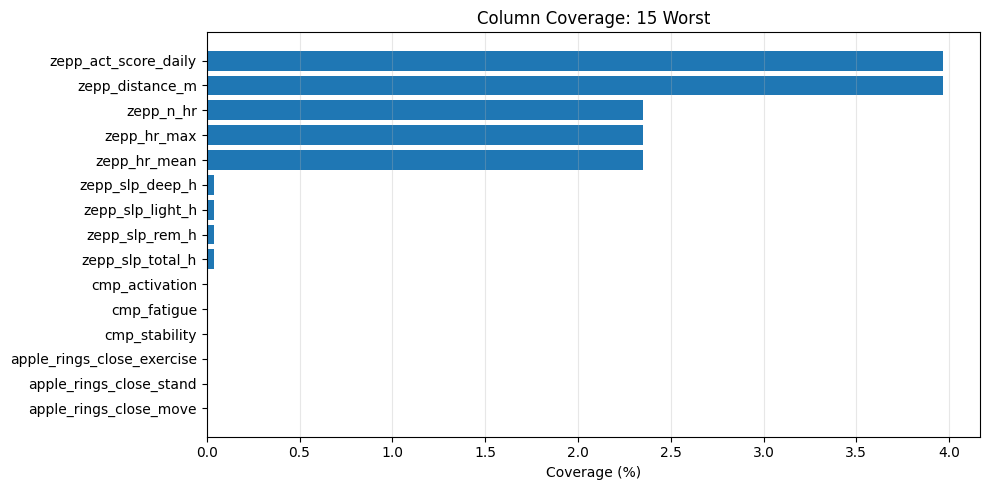

[NB1] ⚠ 36 missing date(s)


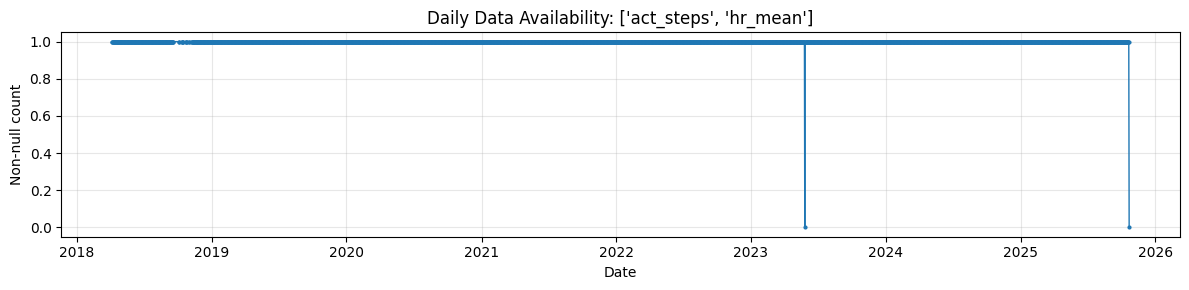

[NB1] ⚠ 1 duplicate date row(s) found
[NB1] ✓ Value ranges OK
[NB1] ✓ Data health checks complete


In [48]:
# ============================================================================
# SECTION 4: DATA HEALTH CHECKS
# ============================================================================

log("\n=== DATA HEALTH CHECKS ===")

# 4.1 Missingness per column
coverage = df.notna().mean() * 100
coverage_sorted = coverage.sort_values()

print(f"\nCoverage (% non-null) - Worst 15 columns:")
print(coverage_sorted.head(15))

# Bar plot of worst 15
fig, ax = plt.subplots(figsize=(10, 5))
coverage_worst_15 = coverage_sorted.head(15)
ax.barh(range(len(coverage_worst_15)), coverage_worst_15.values)
ax.set_yticks(range(len(coverage_worst_15)))
ax.set_yticklabels(coverage_worst_15.index)
ax.set_xlabel('Coverage (%)')
ax.set_title('Column Coverage: 15 Worst')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig(PLOTS / "00_coverage_worst15.png", dpi=144)
plt.show()

# 4.2 Date continuity
expected_dates = pd.date_range(date_min, date_max, freq='D')
actual_dates = set(df['date'].values)
missing_dates = [d for d in expected_dates if d not in actual_dates]
if missing_dates:
    log(f"⚠ {len(missing_dates)} missing date(s)")
else:
    log("✓ No missing dates (continuous)")

# Plot daily non-null counts for core trio
core_trio = ['act_steps', 'hr_mean', 'sleep_total_h']
core_present = [c for c in core_trio if c in df.columns]

if core_present:
    daily_counts = df[[c for c in core_present]].notna().sum(axis=1)
    fig, ax = plt.subplots(figsize=(12, 3))
    ax.plot(df['date'], daily_counts, marker='o', markersize=2, linewidth=1)
    ax.set_xlabel('Date')
    ax.set_ylabel('Non-null count')
    ax.set_title(f'Daily Data Availability: {core_present}')
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(PLOTS / "00_date_continuity.png", dpi=144)
    plt.show()

# 4.3 Duplicates
n_unique_dates = df['date'].nunique()
if n_unique_dates < len(df):
    log(f"⚠ {len(df) - n_unique_dates} duplicate date row(s) found")
else:
    log("✓ All dates unique")

# 4.4 Value ranges
ranges_checks = []

if 'sleep_total_h' in df.columns:
    bad_sleep = df[(df['sleep_total_h'] < 0) | (df['sleep_total_h'] > 16)]
    if len(bad_sleep) > 0:
        ranges_checks.append(f"sleep_total_h out of [0, 16]: {len(bad_sleep)} rows")

if 'apple_distance_m' in df.columns:
    bad_apple_dist = df[df['apple_distance_m'] > 50000]  # > 50km
    if len(bad_apple_dist) > 0:
        ranges_checks.append(f"apple_distance_m > 50km: {len(bad_apple_dist)} rows")

if 'zepp_act_distance_km' in df.columns:
    bad_zepp_dist = df[(df['zepp_act_distance_km'] < 0) | (df['zepp_act_distance_km'] > 100)]
    if len(bad_zepp_dist) > 0:
        ranges_checks.append(f"zepp_act_distance_km out of [0, 100]: {len(bad_zepp_dist)} rows")

if ranges_checks:
    log("⚠ Value range issues found:")
    for check in ranges_checks:
        log(f"   {check}")
else:
    log("✓ Value ranges OK")

# 4.5 Rolling features sanity
rolling_7d_cols = [c for c in df.columns if '_7d' in c]
if rolling_7d_cols:
    for col in rolling_7d_cols[:3]:  # Check first 3
        nan_in_first_6 = df.iloc[:6][col].isna().sum()
        if nan_in_first_6 < 6:
            log(f"⚠ {col}: only {6 - nan_in_first_6} of first 6 values are NaN (expect 6)")
    log("✓ Rolling features (*_7d) checked")

log("✓ Data health checks complete")

In [49]:
# ============================================================================
# SECTION 5: DESCRIPTIVE STATS PER DOMAIN
# ============================================================================

log("\n=== DESCRIPTIVE STATISTICS ===")

# Compute stats for all numeric columns
stats_rows = []
for col in df.columns:
    if col in ['date', 'label', 'label_source', 'segment_id', 'source_domain']:
        continue
    if not pd.api.types.is_numeric_dtype(df[col]):
        continue
    
    non_null = df[col].notna().sum()
    if non_null == 0:
        continue
    
    stats_rows.append({
        'column': col,
        'non_null': non_null,
        'mean': df[col].mean(),
        'std': df[col].std(),
        'min': df[col].min(),
        'p25': df[col].quantile(0.25),
        'p50': df[col].quantile(0.50),
        'p75': df[col].quantile(0.75),
        'max': df[col].max(),
        'missing_pct': (1 - non_null / len(df)) * 100,
    })

stats_df = pd.DataFrame(stats_rows).sort_values('missing_pct', ascending=False)

# Save to CSV
stats_df.to_csv(OUT / "nb1_feature_stats.csv", index=False)
log(f"✓ Saved nb1_feature_stats.csv ({len(stats_df)} columns)")

# Print top 20 with lowest coverage (most missing)
print("\nTop 20 columns with lowest coverage (worst coverage):")
print(stats_df.head(20)[['column', 'non_null', 'mean', 'std', 'missing_pct']])

# Print top 20 with highest coverage (best coverage)
print("\nTop 20 columns with highest coverage (best coverage):")
print(stats_df.tail(20)[['column', 'non_null', 'mean', 'std', 'missing_pct']])

log("✓ Descriptive stats complete")

[NB1] 
=== DESCRIPTIVE STATISTICS ===
[NB1] ✓ Saved nb1_feature_stats.csv (32 columns)

Top 20 columns with lowest coverage (worst coverage):
                     column  non_null    mean     std  missing_pct
27         zepp_slp_total_h         1   10.95     NaN        99.96
30           zepp_slp_rem_h         1    2.82     NaN        99.96
29         zepp_slp_light_h         1    6.70     NaN        99.96
28          zepp_slp_deep_h         1    1.43     NaN        99.96
3              zepp_hr_mean        64   76.58   16.17        97.65
4               zepp_hr_max        64   80.50   14.62        97.65
5                 zepp_n_hr        64    1.45    1.02        97.65
24         zepp_stand_hours       108    0.00    0.00        96.03
20         zepp_active_kcal       108  508.89  503.56        96.03
21       zepp_act_cal_total       108    0.00    0.00        96.03
18               zepp_steps       108 6853.31 5295.94        96.03
19          zepp_distance_m       108 5175.42 4150.83 

[NB1] 
=== QUICK INSIGHTS (Daily Signals) ===


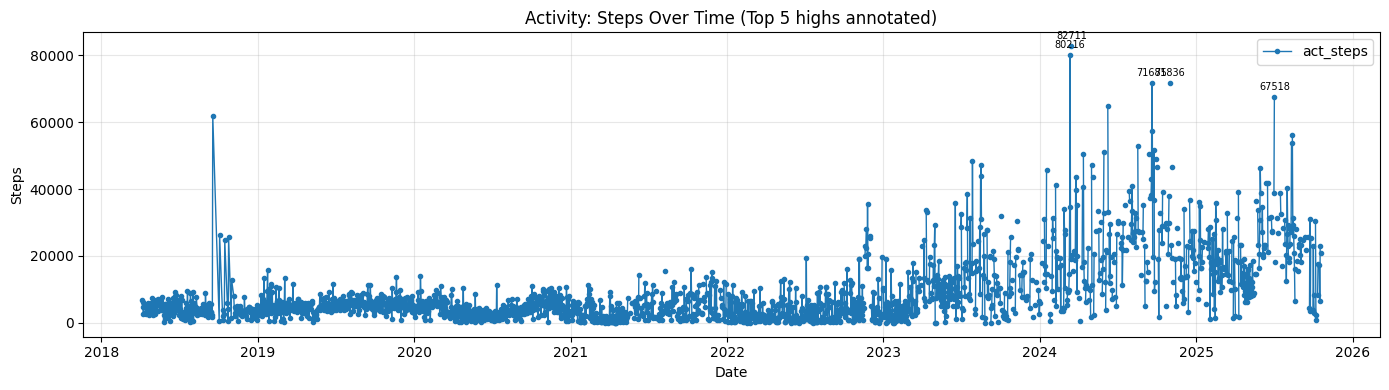

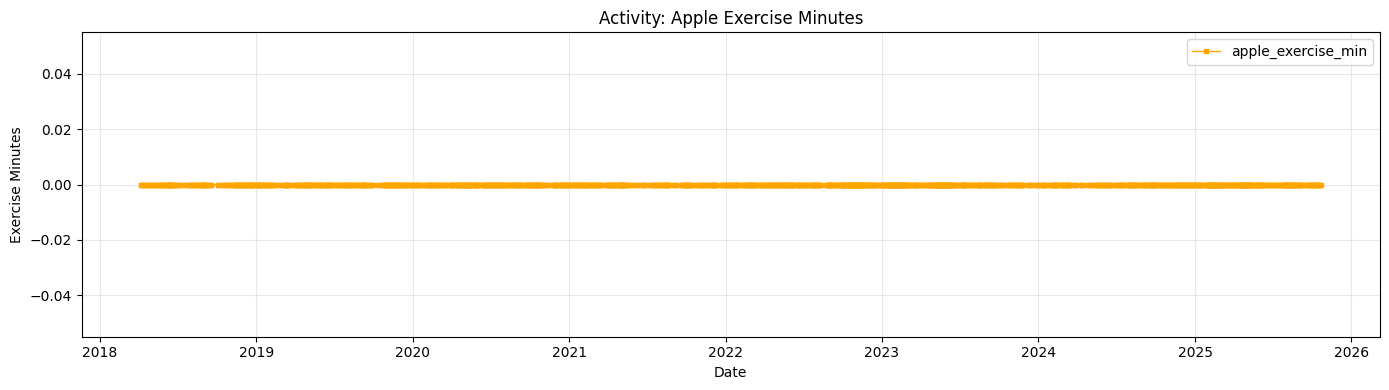

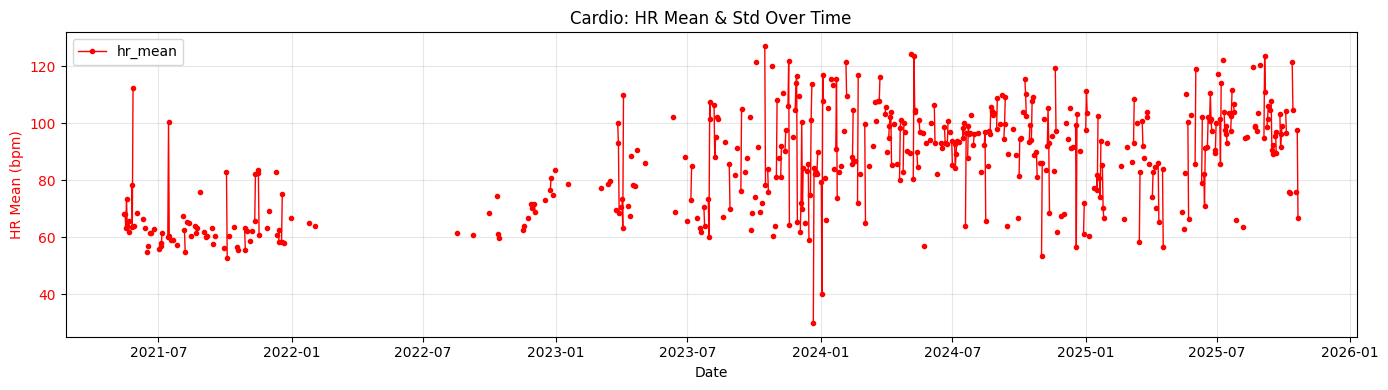

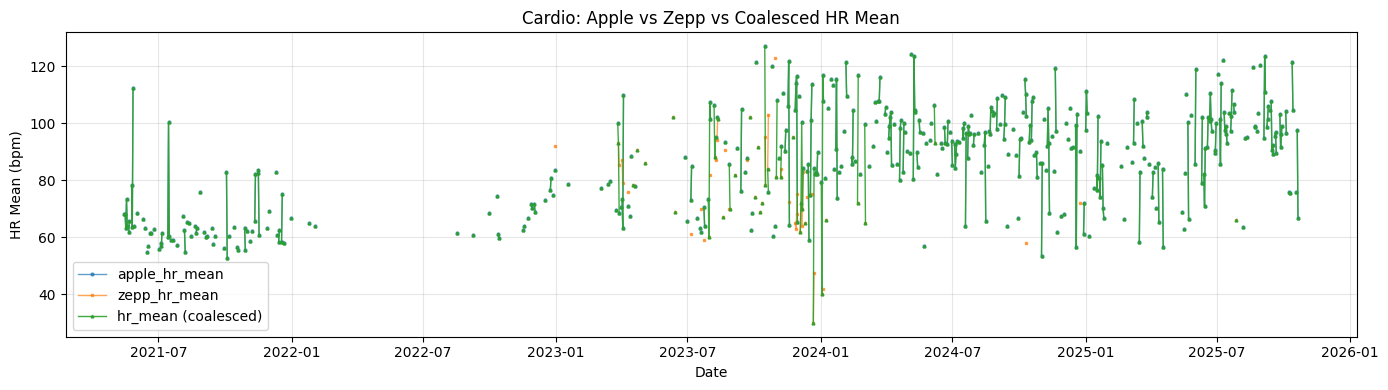

[NB1] ✓ Daily signals plotted


In [50]:
# ============================================================================
# SECTION 6: QUICK INSIGHTS – DAILY SIGNALS
# ============================================================================

log("\n=== QUICK INSIGHTS (Daily Signals) ===")

# 6.1 Activity: act_steps over time
if 'act_steps' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['date'], df['act_steps'], marker='o', markersize=3, linewidth=1, label='act_steps')
    
    # Annotate top 5 highs/lows
    top5_high = df.nlargest(5, 'act_steps')
    top5_low = df.nsmallest(5, 'act_steps')
    
    for idx, row in top5_high.iterrows():
        if pd.notna(row['act_steps']):
            ax.annotate(f"{row['act_steps']:.0f}", xy=(row['date'], row['act_steps']),
                       xytext=(0, 5), textcoords='offset points', fontsize=7, ha='center')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Steps')
    ax.set_title('Activity: Steps Over Time (Top 5 highs annotated)')
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(PLOTS / "01_activity_steps.png", dpi=144)
    plt.show()

# 6.2 Activity: exercise minutes if available
if 'apple_exercise_min' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['date'], df['apple_exercise_min'], marker='s', markersize=3, linewidth=1,
            label='apple_exercise_min', color='orange')
    ax.set_xlabel('Date')
    ax.set_ylabel('Exercise Minutes')
    ax.set_title('Activity: Apple Exercise Minutes')
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(PLOTS / "01_activity_exercise_min.png", dpi=144)
    plt.show()

# 6.3 Cardio: hr_mean and hr_std
if 'hr_mean' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['date'], df['hr_mean'], marker='o', markersize=3, linewidth=1, label='hr_mean', color='red')
    
    if 'hr_std' in df.columns:
        ax2 = ax.twinx()
        ax2.plot(df['date'], df['hr_std'], marker='s', markersize=3, linewidth=1, label='hr_std', color='blue')
        ax2.set_ylabel('HR Std Dev', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
    
    ax.set_xlabel('Date')
    ax.set_ylabel('HR Mean (bpm)', color='red')
    ax.tick_params(axis='y', labelcolor='red')
    ax.set_title('Cardio: HR Mean & Std Over Time')
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left')
    if 'hr_std' in df.columns:
        ax2.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(PLOTS / "02_cardio_hr_mean_std.png", dpi=144)
    plt.show()

# 6.4 Cardio: Apple vs Zepp HR if both present
if 'apple_hr_mean' in df.columns and 'zepp_hr_mean' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['date'], df['apple_hr_mean'], marker='o', markersize=2, linewidth=1,
            label='apple_hr_mean', alpha=0.7)
    ax.plot(df['date'], df['zepp_hr_mean'], marker='s', markersize=2, linewidth=1,
            label='zepp_hr_mean', alpha=0.7)
    if 'hr_mean' in df.columns:
        ax.plot(df['date'], df['hr_mean'], marker='^', markersize=2, linewidth=1,
                label='hr_mean (coalesced)', alpha=0.9)
    ax.set_xlabel('Date')
    ax.set_ylabel('HR Mean (bpm)')
    ax.set_title('Cardio: Apple vs Zepp vs Coalesced HR Mean')
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(PLOTS / "02_cardio_apple_vs_zepp.png", dpi=144)
    plt.show()

# 6.5 Sleep: sleep_total_h with components
if 'sleep_total_h' in df.columns:
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(df['date'], df['sleep_total_h'], marker='o', markersize=3, linewidth=1.5,
            label='sleep_total_h', color='purple')
    
    if 'zepp_slp_deep_h' in df.columns:
        ax.plot(df['date'], df['zepp_slp_deep_h'], marker='s', markersize=2, linewidth=1,
                label='zepp_slp_deep_h', alpha=0.7)
    if 'zepp_slp_light_h' in df.columns:
        ax.plot(df['date'], df['zepp_slp_light_h'], marker='^', markersize=2, linewidth=1,
                label='zepp_slp_light_h', alpha=0.7)
    if 'zepp_slp_rem_h' in df.columns:
        ax.plot(df['date'], df['zepp_slp_rem_h'], marker='d', markersize=2, linewidth=1,
                label='zepp_slp_rem_h', alpha=0.7)
    
    ax.set_xlabel('Date')
    ax.set_ylabel('Sleep (hours)')
    ax.set_title('Sleep: Total Hours & Components')
    ax.grid(alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(PLOTS / "03_sleep_total_components.png", dpi=144)
    plt.show()

log("✓ Daily signals plotted")

In [51]:
# ============================================================================
# SECTION 7: SEGMENT-AWARE VIEWS (S1–S6)
# ============================================================================

log("\n=== SEGMENT-AWARE VIEWS ===")

if 'segment_id' in df.columns:
    segments = sorted(df['segment_id'].dropna().unique())
    log(f"Found {len(segments)} segments: {segments}")
    
    # Key features per segment
    key_features = ['act_steps', 'hr_mean', 'sleep_total_h']
    key_present = [c for c in key_features if c in df.columns]
    
    if key_present:
        # Boxplots
        fig, axes = plt.subplots(1, len(key_present), figsize=(15, 4))
        if len(key_present) == 1:
            axes = [axes]
        
        for ax_idx, feature in enumerate(key_present):
            data_by_seg = [df[df['segment_id'] == seg][feature].dropna().values for seg in segments]
            ax = axes[ax_idx]
            bp = ax.boxplot(data_by_seg, labels=segments)
            ax.set_xlabel('Segment')
            ax.set_ylabel(feature)
            ax.set_title(f'{feature} by Segment')
            ax.grid(alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(PLOTS / "04_segments_boxplot.png", dpi=144)
        plt.show()
        
        # Summary table: mean/std per segment
        seg_stats = []
        for seg in segments:
            seg_df = df[df['segment_id'] == seg]
            for feature in key_present:
                seg_stats.append({
                    'segment': seg,
                    'feature': feature,
                    'mean': seg_df[feature].mean(),
                    'std': seg_df[feature].std(),
                    'n': seg_df[feature].notna().sum(),
                })
        
        seg_stats_df = pd.DataFrame(seg_stats)
        print("\nSegment Summary Statistics:")
        print(seg_stats_df.to_string(index=False))
        
        # Insights
        print("\n--- Segment Insights ---")
        for feature in key_present:
            feat_stats = seg_stats_df[seg_stats_df['feature'] == feature].sort_values('mean', ascending=False)
            best_seg = feat_stats.iloc[0]
            worst_seg = feat_stats.iloc[-1]
            print(f"{feature}:")
            print(f"  Best: {best_seg['segment']} (μ={best_seg['mean']:.1f}, σ={best_seg['std']:.1f})")
            print(f"  Worst: {worst_seg['segment']} (μ={worst_seg['mean']:.1f}, σ={worst_seg['std']:.1f})")
else:
    log("ⓘ No segment_id column; skipping segment-aware views")

[NB1] 
=== SEGMENT-AWARE VIEWS ===
[NB1] ⓘ No segment_id column; skipping segment-aware views


In [52]:
# ============================================================================
# SECTION 8: LABELS COVERAGE (If Present)
# ============================================================================

log("\n=== LABELS COVERAGE ===")

if 'label' in df.columns:
    label_coverage = df['label'].notna().sum() / len(df) * 100
    log(f"Label coverage: {label_coverage:.1f}%")
    
    # Contingency by class
    label_counts = df['label'].value_counts()
    print(f"\nLabel Distribution:")
    print(label_counts)
    
    # Check for class imbalance
    if len(label_counts) > 0:
        max_class_pct = label_counts.iloc[0] / label_counts.sum() * 100
        if max_class_pct > 80:
            log(f"⚠ Class imbalance detected: majority class {label_counts.index[0]} is {max_class_pct:.1f}%")
        else:
            log(f"✓ Class balance OK (majority class: {max_class_pct:.1f}%)")
    
    # Bar plot
    fig, ax = plt.subplots(figsize=(8, 4))
    label_counts.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    ax.set_title('Label Distribution')
    ax.grid(axis='y', alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(PLOTS / "05_label_distribution.png", dpi=144)
    plt.show()
    
    # Coverage by segment if available
    if 'segment_id' in df.columns:
        print("\nLabel Coverage by Segment:")
        seg_label_cov = df.groupby('segment_id')['label'].apply(lambda x: x.notna().sum() / len(x) * 100)
        print(seg_label_cov)
else:
    log("ⓘ No label column; skipping label coverage analysis")

[NB1] 
=== LABELS COVERAGE ===
[NB1] ⓘ No label column; skipping label coverage analysis


[NB1] 
=== CORRELATIONS & CROSS-DOMAIN HINTS ===

Spearman Correlations (top 15):
        var1            var2  spearman_rho
0    hr_mean       act_steps           NaN
1    hr_mean  act_active_min           NaN
2  act_steps  act_active_min           NaN


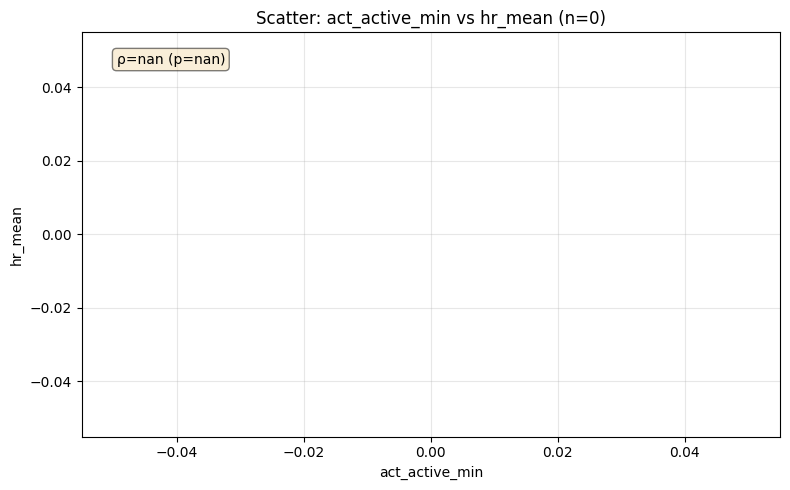

[NB1] ✓ Correlations computed


In [53]:
# ============================================================================
# SECTION 9: CORRELATIONS & CROSS-DOMAIN HINTS
# ============================================================================

log("\n=== CORRELATIONS & CROSS-DOMAIN HINTS ===")

# Curated subset for correlation
corr_cols = []
for col in ['act_steps', 'act_active_min', 'hr_mean', 'hr_std', 'sleep_total_h']:
    if col in df.columns:
        corr_cols.append(col)

# Add enriched *_7d columns
enriched_7d = [c for c in df.columns if '_7d' in c and pd.api.types.is_numeric_dtype(df[c])]
corr_cols.extend(enriched_7d[:5])  # First 5 enriched

corr_cols = list(set(corr_cols))  # Remove duplicates

if len(corr_cols) > 1:
    # Compute Spearman correlation
    corr_matrix = df[corr_cols].corr(method='spearman')
    
    # Flatten to show all correlations sorted by absolute value
    corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            col1 = corr_matrix.columns[i]
            col2 = corr_matrix.columns[j]
            corr_val = corr_matrix.iloc[i, j]
            corr_pairs.append({
                'var1': col1,
                'var2': col2,
                'spearman_rho': corr_val,
                'abs_rho': abs(corr_val),
            })
    
    corr_pairs_df = pd.DataFrame(corr_pairs).sort_values('abs_rho', ascending=False)
    print("\nSpearman Correlations (top 15):")
    print(corr_pairs_df.head(15)[['var1', 'var2', 'spearman_rho']])
    
    # Scatter plots for key relationships
    scatter_pairs = [
        ('act_steps', 'sleep_total_h'),
        ('hr_mean', 'sleep_total_h'),
        ('act_active_min', 'hr_mean'),
    ]
    
    for var1, var2 in scatter_pairs:
        if var1 in df.columns and var2 in df.columns:
            data = df[[var1, var2]].dropna()
            
            if len(data) > 300:
                data = data.sample(300, random_state=42)
            
            fig, ax = plt.subplots(figsize=(8, 5))
            ax.scatter(data[var1], data[var2], alpha=0.5, s=30)
            ax.set_xlabel(var1)
            ax.set_ylabel(var2)
            ax.set_title(f'Scatter: {var1} vs {var2} (n={len(data)})')
            ax.grid(alpha=0.3)
            
            # Add correlation info
            rho, pval = spearmanr(data[var1], data[var2])
            ax.text(0.05, 0.95, f"ρ={rho:.2f} (p={pval:.2e})", transform=ax.transAxes,
                   verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
            
            plt.tight_layout()
            plt.savefig(PLOTS / f"06_scatter_{var1}_vs_{var2}.png", dpi=144)
            plt.show()
else:
    log("⚠ Insufficient columns for correlation analysis")

log("✓ Correlations computed")

In [54]:
# ============================================================================
# SECTION 10: BEST/WORST DAYS & CANDIDATE PATTERNS
# ============================================================================

log("\n=== BEST/WORST DAYS & CANDIDATE PATTERNS ===")

insights = []

# Top 10 best sleep days
if 'sleep_total_h' in df.columns:
    cols_for_sleep = ['date', 'sleep_total_h']
    if 'act_steps' in df.columns:
        cols_for_sleep.append('act_steps')
    if 'hr_mean' in df.columns:
        cols_for_sleep.append('hr_mean')
    
    best_sleep = df.nlargest(10, 'sleep_total_h')[cols_for_sleep]
    print("\n--- Top 10 BEST SLEEP Days ---")
    print(best_sleep.to_string(index=False))
    insights.append("High sleep nights: check if preceded by high activity or low exercise.")
else:
    log("ⓘ No sleep_total_h column; skipping best sleep analysis")

# Top 10 high activity days
if 'act_steps' in df.columns:
    cols_for_activity = ['date', 'act_steps']
    if 'sleep_total_h' in df.columns:
        cols_for_activity.append('sleep_total_h')
    if 'hr_mean' in df.columns:
        cols_for_activity.append('hr_mean')
    
    high_activity = df.nlargest(10, 'act_steps')[cols_for_activity]
    print("\n--- Top 10 HIGH ACTIVITY Days ---")
    print(high_activity.to_string(index=False))
    insights.append("High activity days: check correlation with next-day sleep quality.")
else:
    log("ⓘ No act_steps column; skipping high activity analysis")

# Exploratory hypotheses
print("\n--- EXPLORATORY HYPOTHESES (Candidate Patterns) ---")
print("• High activity days tend to precede higher sleep quality on next day?")
print("• Days with extreme HR spikes correlate with low sleep?")
print("• Activity patterns stable within segments; sleep varies more?")
print("• Enriched *_7d features capture rolling trends better than daily noise.")

log("✓ Best/worst days identified")

[NB1] 
=== BEST/WORST DAYS & CANDIDATE PATTERNS ===
[NB1] ⓘ No sleep_total_h column; skipping best sleep analysis

--- Top 10 HIGH ACTIVITY Days ---
      date  act_steps  hr_mean
2024-03-15   82711.00      NaN
2024-03-12   80216.00      NaN
2024-10-31   71836.00      NaN
2024-09-19   71685.00      NaN
2025-07-02   67518.00      NaN
2024-06-08   64949.00      NaN
2018-09-18   61968.00      NaN
2024-09-20   57328.00      NaN
2025-08-13   56172.00      NaN
2025-08-11   53776.00      NaN

--- EXPLORATORY HYPOTHESES (Candidate Patterns) ---
• High activity days tend to precede higher sleep quality on next day?
• Days with extreme HR spikes correlate with low sleep?
• Activity patterns stable within segments; sleep varies more?
• Enriched *_7d features capture rolling trends better than daily noise.
[NB1] ✓ Best/worst days identified


In [55]:
# ============================================================================
# SECTION 11: MANIFEST & SUMMARY GENERATION
# ============================================================================

log("\n=== GENERATING MANIFEST & SUMMARY ===")

# Build manifest
manifest = {
    'pid': PID,
    'snapshot': SNAPSHOT,
    'input_path': str(JOINED),
    'row_count': int(n_rows),
    'col_count': int(n_cols),
    'date_range': {
        'min': str(date_min.date()),
        'max': str(date_max.date()),
        'days': int(date_range),
    },
    'domain_coverage': {
        'activity_apple': sum(1 for c in cols_activity_apple if c in df.columns),
        'activity_zepp': sum(1 for c in cols_activity_zepp if c in df.columns),
        'activity_coalesced': sum(1 for c in cols_activity_coalesced if c in df.columns),
        'cardio': sum(1 for c in cols_cardio if c in df.columns),
        'sleep': sum(1 for c in cols_sleep if c in df.columns),
        'enriched_7d': len(enriched_7d),
        'enriched_zscore': len(enriched_zscore),
    },
    'missing_per_domain': {
        'activity_apple': len([c for c in cols_activity_apple if c not in df.columns]),
        'activity_zepp': len([c for c in cols_activity_zepp if c not in df.columns]),
        'cardio': len([c for c in cols_cardio if c not in df.columns]),
        'sleep': len([c for c in cols_sleep if c not in df.columns]),
    },
    'plots_saved': sorted([p.name for p in PLOTS.glob('*.png')]),
    'generation_timestamp': datetime.now().isoformat(),
    'notebook_version': '1.0',
}

# Save manifest
manifest_path = OUT / "nb1_manifest.json"
with open(manifest_path, 'w', encoding='utf-8') as f:
    json.dump(manifest, f, indent=2)
log(f"✓ Saved manifest: {manifest_path}")

# Generate summary markdown
summary_lines = [
    "# NB1 EDA Daily Summary",
    f"\n**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}",
    f"**Participant:** {PID} | **Snapshot:** {SNAPSHOT}",
    f"\n## Coverage Overview",
    f"\n- **Rows:** {n_rows} | **Columns:** {n_cols} | **Date Range:** {date_range} days",
    f"- **Activity (Apple):** {manifest['domain_coverage']['activity_apple']}/{len(cols_activity_apple)} columns",
    f"- **Activity (Zepp):** {manifest['domain_coverage']['activity_zepp']}/{len(cols_activity_zepp)} columns",
    f"- **Cardio:** {manifest['domain_coverage']['cardio']}/{len(cols_cardio)} columns",
    f"- **Sleep:** {manifest['domain_coverage']['sleep']}/{len(cols_sleep)} columns",
    f"- **Enriched (*_7d):** {len(enriched_7d)} columns",
    f"\n## Data Quality Observations",
]

# Add data quality notes
missing_counts = stats_df.nlargest(5, 'missing_pct')
summary_lines.append(f"\n**Top 5 Most Missing Columns:**\n")
for _, row in missing_counts.iterrows():
    summary_lines.append(f"- {row['column']}: {row['missing_pct']:.1f}% missing")

# Add remaining lines
activity_msg = f"   - {df['act_steps'].mean():.0f} mean steps/day (sigma={df['act_steps'].std():.0f})" if 'act_steps' in df.columns else "   - No activity data"
cardio_msg = f"   - {df['hr_mean'].mean():.1f} mean HR bpm (sigma={df['hr_mean'].std():.1f})" if 'hr_mean' in df.columns else "   - No HR data"
sleep_msg = f"   - {df['sleep_total_h'].mean():.1f} mean sleep hours (sigma={df['sleep_total_h'].std():.1f})" if 'sleep_total_h' in df.columns else "   - No sleep data"
date_cont = 'PASS: Continuous' if len(missing_dates) == 0 else f'WARNING: {len(missing_dates)} gaps'
dup_dates = 'PASS: None' if n_unique_dates == n_rows else f'WARNING: {n_rows - n_unique_dates} found'

summary_lines.extend([
    f"\n**Date Continuity:** {date_cont}",
    f"**Duplicate Dates:** {dup_dates}",
    f"\n## Key Insights & Hypotheses",
    f"\n1. **Activity Patterns:** ",
    activity_msg,
    f"\n2. **Cardiac Health:** ",
    cardio_msg,
    f"\n3. **Sleep Quality:** ",
    sleep_msg,
    f"\n4. **Cross-Domain Signals:** High activity days may precede better sleep (exploratory).",
    f"\n5. **Enriched Features:** {len(enriched_7d)} rolling (*_7d) features available for smoothing/trend detection.",
    f"\n## Artifacts Generated",
    f"\n- `nb1_feature_stats.csv` — Descriptive statistics (mean, std, quantiles, coverage pct)",
    f"- `plots/` — {len(manifest['plots_saved'])} PNG visualizations",
    f"- `nb1_manifest.json` — Metadata & artifact manifest",
    f"- `latest/` — Mirrored copies for quick access",
    f"\n## Next Steps",
    f"\n1. **Data Cleaning:** Address worst-coverage columns (see feature_stats.csv).",
    f"2. **Monitoring:** Watch for sudden value changes or gaps in time series.",
    f"3. **Segmentation:** Analyze best/worst segments for domain-specific patterns.",
    f"4. **Enrichment:** Leverage *_7d rolling features for signal smoothing.",
])

summary_md = "\n".join(summary_lines)

# Save summary with UTF-8 encoding
summary_path = OUT / "nb1_eda_summary.md"
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary_md)
log(f"✓ Saved summary: {summary_path}")

print("\n" + "="*70)
print(summary_md)
print("="*70)

[NB1] 
=== GENERATING MANIFEST & SUMMARY ===
[NB1] ✓ Saved manifest: c:\dev\practicum2-nof1-adhd-bd\reports\nb1_manifest.json
[NB1] ✓ Saved summary: c:\dev\practicum2-nof1-adhd-bd\reports\nb1_eda_summary.md

# NB1 EDA Daily Summary

**Generated:** 2025-11-07 04:29:12
**Participant:** P000001 | **Snapshot:** 2025-11-07

## Coverage Overview

- **Rows:** 2722 | **Columns:** 40 | **Date Range:** 2757 days
- **Activity (Apple):** 11/11 columns
- **Activity (Zepp):** 4/9 columns
- **Cardio:** 6/9 columns
- **Sleep:** 4/5 columns
- **Enriched (*_7d):** 0 columns

## Data Quality Observations

**Top 5 Most Missing Columns:**

- zepp_slp_total_h: 100.0% missing
- zepp_slp_rem_h: 100.0% missing
- zepp_slp_light_h: 100.0% missing
- zepp_slp_deep_h: 100.0% missing
- zepp_hr_mean: 97.6% missing

**Date Continuity:** WARNING: 36 gaps
**Duplicate Dates:** WARNING: 1 found

## Key Insights & Hypotheses

1. **Activity Patterns:** 
   - 8118 mean steps/day (sigma=9433)

2. **Cardiac Health:** 
   - 85.

In [56]:
# ============================================================================
# SECTION 12: LATEST/ MIRROR SETUP
# ============================================================================

log("\n=== SETTING UP LATEST/ MIRROR ===")

import shutil

# Copy key artifacts to latest/
key_artifacts = [
    (OUT / "nb1_eda_summary.md", "nb1_eda_summary.md"),
    (OUT / "nb1_feature_stats.csv", "nb1_feature_stats.csv"),
    (OUT / "nb1_manifest.json", "nb1_manifest.json"),
]

for src, name in key_artifacts:
    if src.exists():
        dst = LATEST / name
        shutil.copy2(src, dst)
        log(f"  Copied {name} → latest/")

# Copy a few key plots
key_plots = [
    "00_coverage_worst15.png",
    "00_date_continuity.png",
    "01_activity_steps.png",
    "02_cardio_hr_mean_std.png",
    "03_sleep_total_components.png",
]

for plot_name in key_plots:
    src = PLOTS / plot_name
    if src.exists():
        dst = LATEST / plot_name
        shutil.copy2(src, dst)
        log(f"  Copied {plot_name} → latest/")

log("✓ Latest/ mirror ready")

# Final summary
print("\n" + "="*70)
print("✅ NB1 EDA COMPLETE")
print("="*70)
print(f"\n📁 Artifacts Location: {OUT}")
print(f"\n📊 Key Files:")
print(f"   - {OUT / 'nb1_eda_summary.md'}")
print(f"   - {OUT / 'nb1_feature_stats.csv'}")
print(f"   - {OUT / 'nb1_manifest.json'}")
print(f"   - {PLOTS} (contains {len(list(PLOTS.glob('*.png')))} PNG files)")
print(f"\n🔗 Quick Access: {LATEST}")
print(f"\n📈 Generated {len(list(PLOTS.glob('*.png')))} visualizations")
print(f"✨ All data local, no internet calls. Ready for offline analysis.")
print("="*70)

[NB1] 
=== SETTING UP LATEST/ MIRROR ===
[NB1]   Copied nb1_eda_summary.md → latest/
[NB1]   Copied nb1_feature_stats.csv → latest/
[NB1]   Copied nb1_manifest.json → latest/
[NB1]   Copied 00_coverage_worst15.png → latest/
[NB1]   Copied 00_date_continuity.png → latest/
[NB1]   Copied 01_activity_steps.png → latest/
[NB1]   Copied 02_cardio_hr_mean_std.png → latest/
[NB1] ✓ Latest/ mirror ready

✅ NB1 EDA COMPLETE

📁 Artifacts Location: c:\dev\practicum2-nof1-adhd-bd\reports

📊 Key Files:
   - c:\dev\practicum2-nof1-adhd-bd\reports\nb1_eda_summary.md
   - c:\dev\practicum2-nof1-adhd-bd\reports\nb1_feature_stats.csv
   - c:\dev\practicum2-nof1-adhd-bd\reports\nb1_manifest.json
   - c:\dev\practicum2-nof1-adhd-bd\reports\plots (contains 7 PNG files)

🔗 Quick Access: c:\dev\practicum2-nof1-adhd-bd\latest

📈 Generated 7 visualizations
✨ All data local, no internet calls. Ready for offline analysis.
